# Hypothesis testing

In this notebook we demonstrate formal hypothesis testing using the [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) data.

It is important to note that the NHANES data are a "complex survey".  The data are not an independent and representative sample from the target population.  Proper analysis of complex survey data should make use of additional information about how the data were collected.  Since complex survey analysis is a somewhat specialized topic, we ignore this aspect of the data here, and analyze the NHANES data as if it were an independent and identically distributed sample from a population.

First we import the libraries that we will need.

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats.distributions as dist

Below we read the data, and convert some of the integer codes to text values.  The NHANES codebooks for
[SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020),
[RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIAGENDR), and
[DMDCITZN](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDCITZN) describe the meanings of the numerical
codes.

In [6]:
da = pd.read_csv("NHANES.csv")

da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})  # np.nan represents a missing value
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})
da["DMDCITZNx"] = da.DMDCITZN.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

### Paired tests

A common situation in applied research is to measure the same quantity multiple times on each unit of analysis.  For example, in NHANES, systolic blood pressure is measured at least two times (sometimes there is a third measurement) on each subject.  Although the measurements are repeated, there is no guarantee that the mean is the same each time, i.e. the mean blood pressure may be slightly lower on the second measurement compared to the first, since people are a bit more nervous the first time they are measured.  A paired test is a modified form of mean test that can be used when we are comparing two repeated measurements on the same unit.

A paired t-test for means is equivalent to taking the difference between the first and second measurement, and using a one-sample test to compare the mean of these differences to zero. Below we see that in the entire NHANES sample, the first measurement of systolic blood pressure is on average 0.67 mm/Hg greater than the second measurement.  While this difference is not large, it is strongly statistically significant.  That is, there is strong evidence that the mean values for the first and second blood pressure measurement differ.

In [15]:
dx = da[["BPXSY1", "BPXSY2"]].dropna()
db = dx.BPXSY1 - dx.BPXSY2
print(db.mean())
sm.stats.ztest(db)

0.6749860309182343


(9.800634425497911, 1.1188070930963587e-22)

To probe this effect further, we can divide the population into 10 year wide age bands and also stratify by gender, then carry out the paired t-test within each of the resulting 12 strata.  We see that the second systolic blood pressure measurement is always lower on average than the first.  The difference is larger for older people and for males.  The difference is statistically significant for females over 30, and for males over 60.   

Conducting many hypothesis tests and "cherry picking" the interesting results is usually a bad practice.  Here we are doing such "multiple testing" for illustration, and acknowledge that the strongest differences may be over-stated.  Nevertheless, there is a clear and consistent trend with age -- older people tend to have greater differences between their first and second blood pressure measurements than younger people.  There is also a difference between the genders, with older men having a stronger difference between the first and second blood pressure measurements than older women.  The gender difference for younger peple is less clear.

In [25]:
dx = da[["RIAGENDRx", "BPXSY1", "BPXSY2", "RIDAGEYR"]].dropna()
dx["agegrp"] = pd.cut(dx.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
for k, g in dx.groupby(["RIAGENDRx", "agegrp"]):
    db = g.BPXSY1 - g.BPXSY2
    # print stratum definition, mean difference, sample size, test statistic, p-value
    print(k, np.around(db.mean(), 2), db.size, sm.stats.ztest(db.values, value=0))

('Female', Interval(18, 30, closed='right')) 0.14 569 (0.7612107360791227, 0.4465312067051751)
('Female', Interval(30, 40, closed='right')) 0.67 426 (3.307398751951031, 0.0009416674523368051)
('Female', Interval(40, 50, closed='right')) 0.6 469 (2.6040611621024654, 0.009212631487347644)
('Female', Interval(50, 60, closed='right')) 0.77 445 (3.1023718750881724, 0.001919766301204196)
('Female', Interval(60, 70, closed='right')) 0.88 396 (3.1024528501809625, 0.0019192411825181255)
('Female', Interval(70, 80, closed='right')) 1.45 390 (5.141706875154317, 2.722536503552981e-07)
('Male', Interval(18, 30, closed='right')) 0.0 512 (0.01959622841647691, 0.9843654725443948)
('Male', Interval(30, 40, closed='right')) 0.46 432 (1.9451535788714596, 0.05175649697939119)
('Male', Interval(40, 50, closed='right')) 0.18 380 (0.7201800810138878, 0.47141412641258706)
('Male', Interval(50, 60, closed='right')) 0.37 428 (1.4391115097646396, 0.1501189315054144)
('Male', Interval(60, 70, closed='right')) 1.2

## Power and sample size for hypothesis tests

Like nearly any analysis with data, hypothesis tests will yield more sensitive and confident results when there are larger amounts of data.  Here we will study the relationship between the sample size (amount of data), and the behavior of a hypothesis test.  For illustration, we will use the paired t-test for assessing whether the first and second systolic blood pressure measurement have different means, restricting to people between 50 and 60 years of age.

The simulation below randomly subsamples sets of 100, 200, 400, and 800 people from the 50-60 year old subset of NHANES, and conducts a paired z-test on each subsample.  This process is repeated 500 times for each sample size.  We report the fraction of these 500 trials where the p-value was smaller than 0.05.  A higher fraction of trials where p<0.05 implies that it is easier to detect a difference between the first and second blood pressure measurements.  We see that this proportion (called "statistical power") is only around 0.2 when the sample size is 100, and grows to essentially 100% when the sample size is 800.  Note that all of these subsamples are drawn from the same parent population, so there is no change from subsample to subsample in terms of whether the means are truly different.  The only thing that changes is our evidence that the difference is real.  When the sample size is small, we rarely amass such evidence.

In [13]:
all_p = []
dy = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
for n in 100, 200, 400, 800:
    pv = []
    for i in range(500):
        dz = dy.sample(n)
        db = dz.BPXSY1 - dz.BPXSY2
        _, p = sm.stats.ztest(db.values, value=0)
        pv.append(p)
    pv = np.asarray(pv)
    all_p.append(pv)
    print((pv <= 0.05).mean())

0.202
0.37
0.658
1.0


In [27]:
all_p = []
dy = dx.loc[(dx.RIDAGEYR >= 18) & (dx.RIDAGEYR <= 30), :]
for n in 100, 200, 400, 800:
    pv = []
    for i in range(500):
        dz = dy.sample(n)
        db = dz.BPXSY1 - dz.BPXSY2
        _, p = sm.stats.ztest(db.values, value=0)
        pv.append(p)
    pv = np.asarray(pv)
    all_p.append(pv)
    print((pv > 0.05).mean())

0.952
0.956
0.98
0.998


In the simulation code above, we saved all the p-values to the array named `all_p` so we can consider them further here.  The histogram below shows the distribution of p-values for 500 subsamples of data of size 100.  We see that there are more smaller p-values than larger ones, but not to a dramatic degree.  Some of the p-values are almost 1, indicating that the subsample mean differences were almost zero in those cases.

/Users/daddy/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: ylabel='Density'>

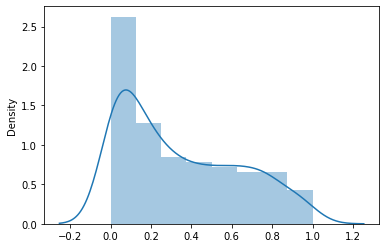

In [20]:
sns.distplot(all_p[0])

Next we inspect the distribution of p-values for subsamples of size 400.  We see that the p-values are much more concentrated close to zero compared to when we had only 100 data points.  If we obtain a sample of size 400 from this population, we have around a 70% chance of obtaining a p-value smaller than 0.05, and are very unlikely to obtain a p-value greater than 0.4.

/Users/daddy/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: ylabel='Density'>

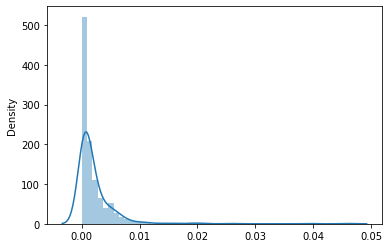

In [41]:
sns.distplot(all_p[3])

In [23]:
type(all_p)

list

In [26]:
len(all_p)

4

In [29]:
len(all_p[0])

500

In [39]:
all_p[3].mean()

0.0021733958863656834